In [6]:
# !pip3 install kagglehub
# !pip3 install torch torchvision torchaudio
# !pip3 install matplotlib

In [7]:
import kagglehub
import torch
import os
import torch
from networkx.algorithms.lowest_common_ancestors import tree_all_pairs_lowest_common_ancestor
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import torchvision
from tqdm import tqdm


In [2]:
#!pip install --upgrade certifi
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
torch.cuda.is_available()

True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cuda')

In [11]:
dataset_path = kagglehub.dataset_download('weiming97/hrsc2016-ms-dataset')

In [12]:
#dataset_path = "/Users/mahdi/.cache/kagglehub/datasets/weiming97/hrsc2016-ms-dataset/versions/1"

In [13]:
print(dataset_path)

/kaggle/input/hrsc2016-ms-dataset


## Dataset Creation

In [14]:
class ShipDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_set_file, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        with open(image_set_file, 'r') as f:
            self.image_ids = [line.strip() for line in f]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.images_dir, f"{image_id}.bmp")
        ann_path = os.path.join(self.annotations_dir, f"{image_id}.xml")
        image = Image.open(img_path).convert("RGB")
        midpoint_boxes = []

        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            robnd = obj.find('robndbox')
            if robnd is None:
                continue
            cx = float(robnd.find('cx').text)
            cy = float(robnd.find('cy').text)
            w = float(robnd.find('w').text)
            h = float(robnd.find('h').text)
            angle = float(robnd.find('angle').text)
            
            
            cos_a = np.cos(angle)
            sin_a = np.sin(angle)
            dx, dy = w/2, h/2
            corners = np.array([[-dx,-dy],[dx,-dy],[dx,dy],[-dx,dy]])
            rot = np.array([[cos_a,-sin_a],[sin_a,cos_a]])
            rot_corners = corners @ rot.T
            trans = rot_corners + np.array([cx,cy])
            
            bnd = obj.find('bndbox')
            if bnd is None:
                continue
            w_h = float(bnd.find('xmax').text) - float(bnd.find('xmin').text)
            h_h = float(bnd.find('ymax').text) - float(bnd.find('ymin').text)
            top_mid = np.array([cx, cy - h_h/2])
            right_mid = np.array([cx + w_h/2, cy])
            
            v1, v2 = trans[0], trans[1]
            delta_alpha = v1[0] - top_mid[0]
            delta_beta  = v2[1] - right_mid[1]
            midpoint_boxes.append([cx, cy, w_h, h_h, delta_alpha, delta_beta])

        midpoint_boxes = torch.tensor(midpoint_boxes, dtype=torch.float32)
        target = {'midpoint_boxes': midpoint_boxes}
        if self.transform:
            image = self.transform(image)
        else:
            image = image
        return image, target

In [15]:

train_dataset = ShipDataset(
    images_dir=os.path.join(dataset_path,"AllImages"),
    annotations_dir=os.path.join(dataset_path,"Annotations"),
    image_set_file=os.path.join(dataset_path,'ImageSets/train.txt'),
    
)

In [16]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=1144x820>,
 {'midpoint_boxes': tensor([[ 709.5618,  375.9656,  372.0000,  456.0000,  132.4550, -179.1230]])})

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_image_with_midpoints(image, target):
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(image).astype(np.uint8))

    mid_boxes = target.get('midpoint_boxes')  # (x, y, w, h, Δα, Δβ)

    for i in range(len(mid_boxes)):
        
        x, y, w, h, delta_alpha, delta_beta = mid_boxes[i].tolist()

        v1 = (x + delta_alpha, y - h / 2) 
        v2 = (x + w / 2, y + delta_beta)    
        v3 = (x - delta_alpha, y + h / 2)   
        v4 = (x - w / 2, y - delta_beta)

        corners_mid = np.array([v1, v2, v3, v4])

        polygon_mid = patches.Polygon(corners_mid, closed=True,
                                      edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(polygon_mid)

    plt.axis('off')
    plt.show()


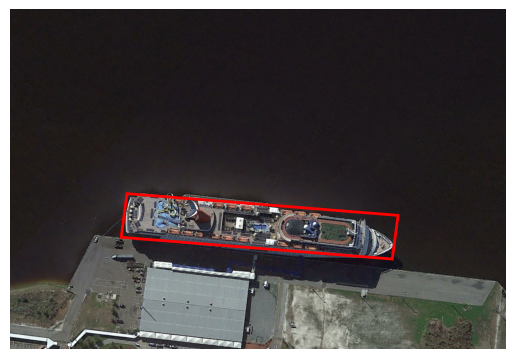

In [18]:
plot_image_with_midpoints(train_dataset[89][0], train_dataset[89][1])


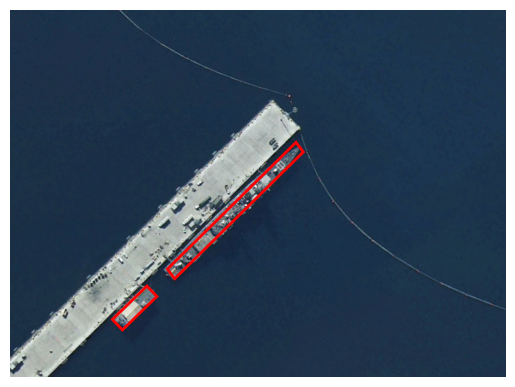

In [19]:
plot_image_with_midpoints(train_dataset[389][0], train_dataset[389][1])

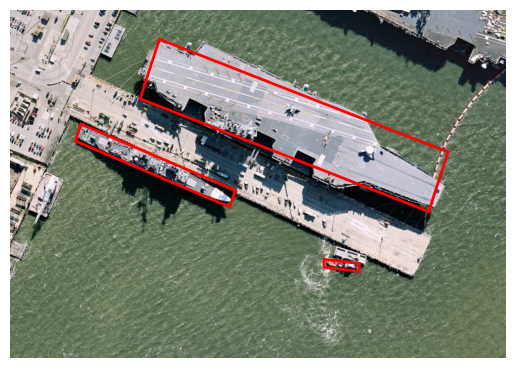

In [20]:
plot_image_with_midpoints(train_dataset[94][0], train_dataset[94][1])

In [21]:
import torchvision
import torch.nn as nn

In [35]:
backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [36]:
backbone

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [37]:
backbone.backbone.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0-3): 4 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelMaxPool()
)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet50
from torchvision.ops import nms, box_iou
import numpy as np


class OrientedRPN(nn.Module):
    def __init__(self, in_channels=256, num_anchors=3): # num_anchors is an argument here
        super().__init__()
        self.in_channels = in_channels
        self.num_anchors = num_anchors
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.cls_logits = nn.Conv2d(in_channels, self.num_anchors * 2, 1) # Use self.num_anchors
        self.bbox_pred = nn.Conv2d(in_channels, self.num_anchors * 6, 1)  # Use self.num_anchors
        for l in [self.conv, self.cls_logits, self.bbox_pred]:
            nn.init.normal_(l.weight, std=0.01)
            nn.init.constant_(l.bias, 0)

    def forward(self, features):
        cls_scores_out = []
        bbox_preds_out = []
        for x_level_feat in features:
            t = F.relu(self.conv(x_level_feat))
            cls_output = self.cls_logits(t)
            cls_scores_out.append(cls_output)
            bbox_preds_out.append(self.bbox_pred(t))
        return cls_scores_out, bbox_preds_out

In [39]:
import torch
import torch.nn.functional as F

class RotatedRoIAlign(nn.Module):
    def __init__(self, output_size=(7,7), spatial_scale=1.0):
        super().__init__()
        self.output_size, self.spatial_scale = output_size, spatial_scale

    def forward(self, feature, rois):

        device = feature.device
        N, C = rois.size(0), feature.size(0)
        H_out, W_out = self.output_size
        output = torch.zeros(N, C, H_out, W_out, device=device)


        H_feat, W_feat = feature.size(1), feature.size(2)
        for i in range(N):
            x, y, w, h, theta = rois[i]
    
            x_s = x * self.spatial_scale
            y_s = y * self.spatial_scale
            w_s = w * self.spatial_scale
            h_s = h * self.spatial_scale


            grid_y = torch.linspace(-0.5, 0.5, H_out, device=device)
            grid_x = torch.linspace(-0.5, 0.5, W_out, device=device)
            grid_y, grid_x = torch.meshgrid(grid_y, grid_x, indexing='ij')
            grid = torch.stack([grid_x * w_s, grid_y * h_s], dim=-1)


            cos_t, sin_t = torch.cos(theta), torch.sin(theta)
            R = torch.tensor([[cos_t, -sin_t], [sin_t, cos_t]], device=device)
            grid_rot = grid @ R

           
            coords = grid_rot + torch.tensor([x_s, y_s], device=device)

            
            coords_norm = coords.clone()
            coords_norm[..., 0] = coords_norm[..., 0] / (W_feat - 1) * 2 - 1
            coords_norm[..., 1] = coords_norm[..., 1] / (H_feat - 1) * 2 - 1
            coords_norm = coords_norm.unsqueeze(0)

            feat = feature.unsqueeze(0)
            
            sampled = F.grid_sample(feat, coords_norm, align_corners=True)

            output[i] = sampled.squeeze(0)

        return output


In [40]:
class AnchorGenerator:
    def __init__(self, scales=[32, 64, 128, 256, 512], ratios=[0.5, 1.0, 2.0], strides=[4, 8, 16, 32, 64]):
        self.scales = scales
        self.ratios = ratios
        self.strides = strides

    def generate(self, feature_shapes, device):
        anchors = []
        for scale, stride, (h, w) in zip(self.scales, self.strides, feature_shapes):
            areas = scale * scale
            sizes = [np.sqrt(areas / r) for r in self.ratios]
            ws = [s * np.sqrt(r) for s, r in zip(sizes, self.ratios)]
            hs = [s / np.sqrt(r) for s, r in zip(sizes, self.ratios)]
            x_centers = torch.arange(0, w, device=device) * stride + stride / 2
            y_centers = torch.arange(0, h, device=device) * stride + stride / 2
            x_centers, y_centers = torch.meshgrid(x_centers, y_centers, indexing='ij')
            x_centers = x_centers.flatten()
            y_centers = y_centers.flatten()
            for w, h in zip(ws, hs):
                anchor = torch.stack([
                    x_centers, y_centers,
                    torch.full_like(x_centers, w),
                    torch.full_like(y_centers, h)
                ], dim=-1)
                anchors.append(anchor)
        return torch.cat(anchors)

In [41]:
class OrientedRCNNHead(nn.Module):
    def __init__(self, in_channels=256, num_classes=2):
        super().__init__()
        self.roi_align = RotatedRoIAlign(output_size=(7,7), spatial_scale=1.0)
        self.fc1  = nn.Linear(in_channels * 7 * 7, 1024)
        self.fc2  = nn.Linear(1024, 1024)
        self.cls_score   = nn.Linear(1024, num_classes)
        self.bbox_refine = nn.Linear(1024, num_classes * 6)

    def forward(self, features, proposals):

        if features.dim() == 4 and features.size(0) == 1:
            feature = features[0]      # now [C, H, W]
        elif features.dim() == 3:
            feature = features         # already [C, H, W]
        else:
            raise NotImplementedError("OrientedRCNNHead only supports batch_size=1")


        x = self.roi_align(feature, proposals)  # now receives [C,H,W]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        scores     = self.cls_score(x)
        bbox_deltas= self.bbox_refine(x)
        return scores, bbox_deltas


In [42]:
class OrientedRCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(OrientedRCNN, self).__init__()
        self.backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        if hasattr(self.backbone, 'backbone'): 
            self.body = self.backbone.backbone.body
            self.fpn = self.backbone.backbone.fpn
        else:
            self.body = self.backbone.body
            self.fpn = self.backbone.fpn

        self.fpn_out_channels = 256
        self.rpn = OrientedRPN(in_channels=self.fpn_out_channels, num_anchors=3)
        self.head = OrientedRCNNHead(num_classes=num_classes, in_channels=self.fpn_out_channels) 
        self.anchor_generator = AnchorGenerator()

    def forward(self, images, targets=None):

        features_from_body = self.body(images.tensors if isinstance(images, torchvision.models.detection.image_list.ImageList) else images)

        fpn_features_dict = self.fpn(features_from_body)


        fpn_features_list = list(fpn_features_dict.values())
        feature_shapes = [(f.size(2), f.size(3)) for f in fpn_features_list]
        device_to_use = images.tensors.device if isinstance(images, torchvision.models.detection.image_list.ImageList) else images.device
        anchors = self.anchor_generator.generate(feature_shapes, device=device_to_use)

    
        rpn_raw_cls_scores, rpn_raw_bbox_preds = self.rpn(fpn_features_list)

        proposals_collected = [] # Renamed to avoid confusion
        anchor_start_index = 0

        for level_idx in range(len(rpn_raw_cls_scores)):
            cls_level_output = rpn_raw_cls_scores[level_idx] # This is 4D: [B, C_cls, H, W]
            bbox_level_output = rpn_raw_bbox_preds[level_idx] # This is 4D: [B, C_bbox, H, W]

            batch_s, _, h_feat, w_feat = cls_level_output.shape

            num_anchors_per_loc = self.rpn.num_anchors


            local_cls_scores_reshaped = cls_level_output.view(batch_s, num_anchors_per_loc, 2, h_feat, w_feat).permute(0, 3, 4, 1, 2).contiguous().view(batch_s, h_feat * w_feat * num_anchors_per_loc, 2)
            local_bbox_preds_reshaped = bbox_level_output.view(batch_s, num_anchors_per_loc, 6, h_feat, w_feat).permute(0, 3, 4, 1, 2).contiguous().view(batch_s, h_feat * w_feat * num_anchors_per_loc, 6)

            num_anchors_this_level = h_feat * w_feat * num_anchors_per_loc
            anchors_this_level = anchors[anchor_start_index : anchor_start_index + num_anchors_this_level]
            anchor_start_index += num_anchors_this_level

            for b_idx in range(batch_s): # Process each image in the batch
                cls_b_level = local_cls_scores_reshaped[b_idx].sigmoid() # [H*W*num_anchors, 2]
                bbox_b_level = local_bbox_preds_reshaped[b_idx]          # [H*W*num_anchors, 6]

                props_b_level = self.decode_proposals(anchors_this_level, bbox_b_level) # [H*W*num_anchors, 5]
                scores_b_level = cls_b_level[:, 1] # Foreground scores

                props_xyxy = torch.stack([
                    props_b_level[:, 0] - props_b_level[:, 2] / 2,
                    props_b_level[:, 1] - props_b_level[:, 3] / 2,
                    props_b_level[:, 0] + props_b_level[:, 2] / 2,
                    props_b_level[:, 1] + props_b_level[:, 3] / 2
                ], dim=1)

                keep_indices = torchvision.ops.nms(props_xyxy, scores_b_level, 0.8) # Using torchvision.ops.nms

                proposals_after_nms = props_b_level[keep_indices[:2000]] # Top 2000 from this level for this image

                if batch_s == 1:
                    proposals_collected.append(proposals_after_nms)

        if proposals_collected: # Check if not empty
            final_proposals_for_head = torch.cat(proposals_collected, dim=0)

            if final_proposals_for_head.shape[0] > 1000: # Example limit
                 final_proposals_for_head = final_proposals_for_head[:1000]
        else: 
            final_proposals_for_head = torch.empty((0, 5), device=device_to_use, dtype=torch.float32)

        head_input_feature = fpn_features_list[0] if fpn_features_list else torch.empty((0,0,0,0), device=device_to_use)

        head_cls_scores, head_bbox_deltas = self.head(head_input_feature, final_proposals_for_head)

        if self.training:
            loss_rpn = self.compute_rpn_loss(rpn_raw_cls_scores, rpn_raw_bbox_preds, anchors, targets)
            loss_rcnn = self.compute_rcnn_loss(head_cls_scores, head_bbox_deltas, final_proposals_for_head, targets)
            return {"rpn_loss": loss_rpn, "rcnn_loss": loss_rcnn}

      
        return final_proposals_for_head, head_cls_scores, head_bbox_deltas

    def decode_proposals(self, anchors, bbox_preds):
        x = anchors[:, 0] + bbox_preds[:, 0] * anchors[:, 2]
        y = anchors[:, 1] + bbox_preds[:, 1] * anchors[:, 3]
        w = anchors[:, 2] * torch.exp(bbox_preds[:, 2])
        h = anchors[:, 3] * torch.exp(bbox_preds[:, 3])
        delta_alpha = bbox_preds[:, 4] * anchors[:, 2]
        delta_beta = bbox_preds[:, 5] * anchors[:, 3]
        theta = torch.atan2(delta_beta, delta_alpha)
        return torch.stack([x, y, w, h, theta], dim=1)

    def compute_rpn_loss(self, cls_scores, bbox_preds, anchors, targets):

        batch_size = len(targets)
        rpn_cls_loss_total = 0.0
        rpn_reg_loss_total = 0.0

        for i in range(batch_size):
            gt_boxes_item = targets[i]["midpoint_boxes"] 
            device = gt_boxes_item.device
            if gt_boxes_item.numel() == 0:
                continue


            gt_horizontal_boxes = torch.stack([
                gt_boxes_item[:, 0] - gt_boxes_item[:, 2] / 2, # xmin
                gt_boxes_item[:, 1] - gt_boxes_item[:, 3] / 2, # ymin
                gt_boxes_item[:, 0] + gt_boxes_item[:, 2] / 2, # xmax
                gt_boxes_item[:, 1] + gt_boxes_item[:, 3] / 2  # ymax
            ], dim=1)

            anchors_xyxy = torch.stack([
                anchors[:, 0] - anchors[:, 2] / 2, # xmin
                anchors[:, 1] - anchors[:, 3] / 2, # ymin
                anchors[:, 0] + anchors[:, 2] / 2, # xmax
                anchors[:, 1] + anchors[:, 3] / 2  # ymax
            ], dim=1)

            iou = box_iou(anchors_xyxy, gt_horizontal_boxes) # [num_total_anchors, num_gt]
            max_iou_per_anchor, max_iou_idx_per_anchor = iou.max(dim=1)


            labels = torch.full((anchors.size(0),), -1, dtype=torch.long, device=device) # Initialize with -1 (ignore)
            labels[max_iou_per_anchor < 0.3] = 0  # Background
            labels[max_iou_per_anchor >= 0.7] = 1 # Foreground


            if gt_horizontal_boxes.shape[0] > 0:
                 max_iou_per_gt, _ = iou.max(dim=0) 
                 gt_max_iou_anchors_idx = torch.where(iou == max_iou_per_gt.unsqueeze(0))[0] 

                for j in range(gt_boxes_item.size(0)):
                     gt_iou_for_this_gt = iou[:, j]
                     if gt_iou_for_this_gt.max() > 0.3: 
                         labels[gt_iou_for_this_gt.argmax()] = 1


            positive_idx = (labels == 1).nonzero(as_tuple=False).flatten()
            negative_idx = (labels == 0).nonzero(as_tuple=False).flatten()

            num_samples = 256 
            num_positive = min(len(positive_idx), num_samples // 2) # Max 128 positive

            if num_positive > 0:
                pos_perm = torch.randperm(len(positive_idx), device=device)[:num_positive]
                sampled_positive_idx = positive_idx[pos_perm]
            else:
                sampled_positive_idx = torch.tensor([], dtype=torch.long, device=device)

            num_negative = num_samples - num_positive
            if len(negative_idx) > 0 and num_negative > 0: # Ensure there are negatives to sample and we need to sample them
                neg_perm = torch.randperm(len(negative_idx), device=device)[:num_negative]
                sampled_negative_idx = negative_idx[neg_perm]
            else:
                sampled_negative_idx = torch.tensor([], dtype=torch.long, device=device)

            sampled_idx = torch.cat([sampled_positive_idx, sampled_negative_idx])

            if sampled_idx.numel() == 0: 
                # rpn_cls_loss_total += torch.tensor(0.0, device=device)
                # rpn_reg_loss_total += torch.tensor(0.0, device=device)
                continue


            cls_preds_for_item_i_flat_list = []
            bbox_preds_for_item_i_flat_list = []


            num_rpn_anchors_per_loc = self.rpn.num_anchors 

            for level_k in range(len(cls_scores)): 
                cls_level_all_batch = cls_scores[level_k]   
                bbox_level_all_batch = bbox_preds[level_k] 

                cls_level_item_i = cls_level_all_batch[i]   

                try:

                    cls_processed = cls_level_item_i.permute(1, 2, 0).contiguous().view(-1, 2)
                    cls_preds_for_item_i_flat_list.append(cls_processed)

   
                    bbox_processed = bbox_level_item_i.permute(1, 2, 0).contiguous().view(-1, 6)
                    bbox_preds_for_item_i_flat_list.append(bbox_processed)

                except RuntimeError as e:
                    import pdb; pdb.set_trace()
                    raise e


            cls_flat_item_i = torch.cat(cls_preds_for_item_i_flat_list, dim=0)  
            bbox_flat_item_i = torch.cat(bbox_preds_for_item_i_flat_list, dim=0)


            cls_pred_sampled = cls_flat_item_i[sampled_idx]
            labels_sampled = labels[sampled_idx]

 
            valid_loss_indices = labels_sampled != -1
            if valid_loss_indices.sum() > 0 :
                cls_loss_item = F.cross_entropy(cls_pred_sampled[valid_loss_indices], labels_sampled[valid_loss_indices])
            else:
                cls_loss_item = torch.tensor(0.0, device=device)


            pos_sampled_idx_for_reg = sampled_idx[labels_sampled == 1]

            if len(pos_sampled_idx_for_reg) > 0:
                assigned_gt_idx = max_iou_idx_per_anchor[pos_sampled_idx_for_reg]
                gt_midpoint_targets = gt_boxes_item[assigned_gt_idx] # [num_pos_sampled, 6]
                anchors_pos = anchors[pos_sampled_idx_for_reg]       # [num_pos_sampled, 4] (cx, cy, w, h)


                t_x_star = (gt_midpoint_targets[:, 0] - anchors_pos[:, 0]) / anchors_pos[:, 2]
                t_y_star = (gt_midpoint_targets[:, 1] - anchors_pos[:, 1]) / anchors_pos[:, 3]
                t_w_star = torch.log(gt_midpoint_targets[:, 2] / anchors_pos[:, 2])
                t_h_star = torch.log(gt_midpoint_targets[:, 3] / anchors_pos[:, 3])
                t_alpha_star = gt_midpoint_targets[:, 4] / anchors_pos[:, 2] # da_g / w_a
                t_beta_star = gt_midpoint_targets[:, 5] / anchors_pos[:, 3]  # db_g / h_a

                t_star = torch.stack([t_x_star, t_y_star, t_w_star, t_h_star, t_alpha_star, t_beta_star], dim=1)

                bbox_pred_pos_sampled = bbox_flat_item_i[pos_sampled_idx_for_reg] # Predictions for these positive anchors
                reg_loss_item = F.smooth_l1_loss(bbox_pred_pos_sampled, t_star, reduction='sum') / max(1, len(pos_sampled_idx_for_reg)) # Normalize by num positive
            else:
                reg_loss_item = torch.tensor(0.0, device=device)

            rpn_cls_loss_total += cls_loss_item
            rpn_reg_loss_total += reg_loss_item


        final_rpn_cls_loss = rpn_cls_loss_total / batch_size if batch_size > 0 else torch.tensor(0.0, device=anchors.device)
        final_rpn_reg_loss = rpn_reg_loss_total / batch_size if batch_size > 0 else torch.tensor(0.0, device=anchors.device)

        return final_rpn_cls_loss + final_rpn_reg_loss

    def compute_rcnn_loss(self, cls_scores, bbox_deltas, proposals, targets):
        return torch.tensor(0.0, device=cls_scores.device, requires_grad=True)


In [43]:
from torch.utils.data import DataLoader

In [44]:
import torch
import torch.nn.functional as F
    # Custom collate to pad images and collect targets
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    max_h = max(img.size(1) for img in images)
    max_w = max(img.size(2) for img in images)
    padded = []
    for img in images:
        pad_h = max_h - img.size(1)
        pad_w = max_w - img.size(2)
        padded.append(F.pad(img, (0, pad_w, 0, pad_h)))
    images = torch.stack(padded).to(device)
    return images, targets

In [45]:

train_dataset = ShipDataset(
    images_dir=os.path.join(dataset_path,"AllImages"),
    annotations_dir=os.path.join(dataset_path,  "Annotations"),
    image_set_file=os.path.join(dataset_path,  'ImageSets/train.txt'),
    transform=torchvision.transforms.ToTensor()
)



In [49]:
def train_oriented_rcnn(model, 
                        train_dataset, 
                        device=None,
                        batch_size=1, 
                        epochs=36, 
                        learning_rate=0.002, 
                        weight_decay=1e-4, 
                        momentum=0.9):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    model.to(device)
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(0.7*epochs), gamma=0.1)


    epoch_losses = []
    epoch_rpn_acc = []

    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}")
        for images, targets in loop:
            images = images.to(device)

            targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
            

            losses = model(images, targets)
            loss = sum(losses.values())

            batch_acc = float('nan')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        scheduler.step()
        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        epoch_rpn_acc.append(batch_acc)  

        print(f"[Epoch {epoch}] Avg Loss: {avg_loss:.4f} | RPN Acc: {batch_acc:.4f}")

    print("Training complete.")
    return model, epoch_losses, epoch_rpn_acc


In [50]:
device

device(type='cuda')

In [53]:

model = OrientedRCNN(num_classes=2).to(device)

model, losses, accs = train_oriented_rcnn(model, train_dataset, device=device, epochs=8)


Epoch 1/8: 100%|██████████| 610/610 [56:57<00:00,  5.60s/it, loss=0.186] 


[Epoch 1] Avg Loss: 0.4249 | RPN Acc: nan


Epoch 2/8: 100%|██████████| 610/610 [56:53<00:00,  5.60s/it, loss=0.257] 


[Epoch 2] Avg Loss: 0.3804 | RPN Acc: nan


Epoch 3/8: 100%|██████████| 610/610 [56:41<00:00,  5.58s/it, loss=0.344] 


[Epoch 3] Avg Loss: 0.3612 | RPN Acc: nan


Epoch 4/8: 100%|██████████| 610/610 [56:40<00:00,  5.58s/it, loss=0.559] 


[Epoch 4] Avg Loss: 0.3483 | RPN Acc: nan


Epoch 5/8: 100%|██████████| 610/610 [56:45<00:00,  5.58s/it, loss=0.231] 


[Epoch 5] Avg Loss: 0.3295 | RPN Acc: nan


Epoch 6/8: 100%|██████████| 610/610 [57:18<00:00,  5.64s/it, loss=0.136] 


[Epoch 6] Avg Loss: 0.2789 | RPN Acc: nan


Epoch 7/8: 100%|██████████| 610/610 [57:39<00:00,  5.67s/it, loss=0.309]  


[Epoch 7] Avg Loss: 0.2561 | RPN Acc: nan


Epoch 8/8: 100%|██████████| 610/610 [57:21<00:00,  5.64s/it, loss=0.0784] 

[Epoch 8] Avg Loss: 0.2404 | RPN Acc: nan
Training complete.


In [55]:

def plot_loss_for_training(train_loss_history, model_name):
    plt.figure(figsize=(12, 6))
    plt.title(f"{model_name}Training")

    plt.plot(train_loss_history, label='Train Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.legend()

    
    # Show the plot
    plt.tight_layout()
    plt.show()

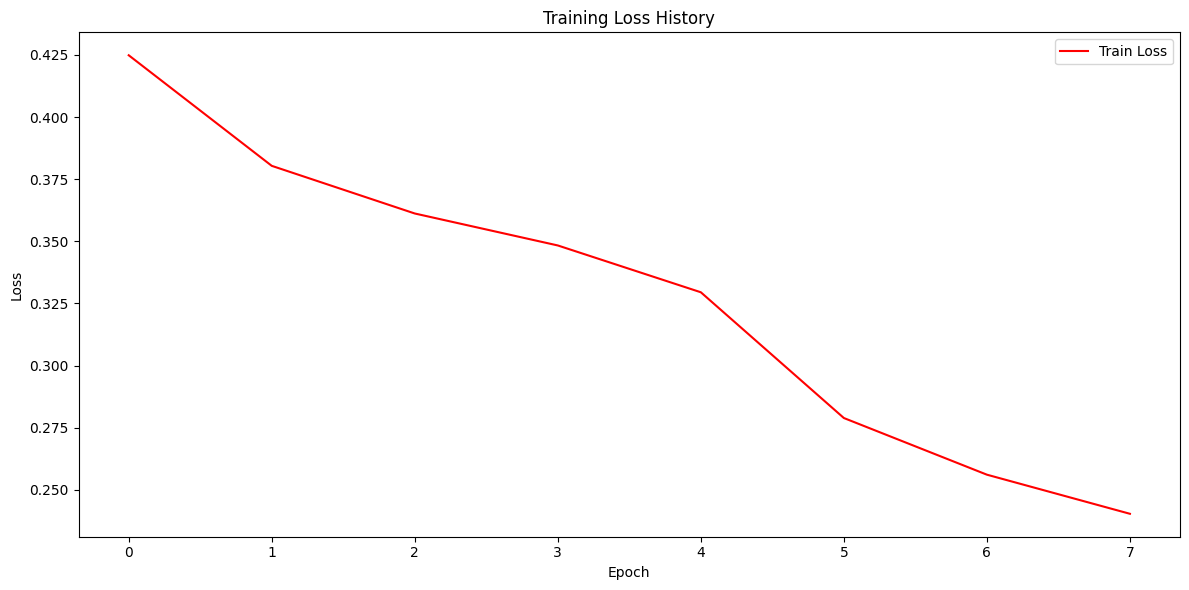

In [56]:
plot_loss_for_training(losses,"Oriented RCNN")

In [57]:
test_dataset = ShipDataset(
    images_dir=os.path.join(dataset_path, "AllImages"),
    annotations_dir=os.path.join(dataset_path, "Annotations"),
    image_set_file=os.path.join(dataset_path, "ImageSets/test.txt"),
    transform=torchvision.transforms.ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)


In [71]:
def visualize_predictions(model, dataloader, device, num_samples=5, score_thresh=0.5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple) and len(outputs) == 3:
                proposals, cls_scores, bbox_deltas = outputs
            else:
                print("Unexpected model output.")
                return

            for i in range(images.shape[0]):
                img_pil = TF.to_pil_image(images[i].cpu())

                # Decode predicted boxes
                prop = proposals
                deltas = bbox_deltas
                scores = F.softmax(cls_scores, dim=1)  # [N, C]

                class_scores, class_ids = scores.max(dim=1)
                keep = (class_ids > 0) & (class_scores > score_thresh)

                prop = prop[keep]
                deltas = deltas[keep]
                class_scores = class_scores[keep]

                if len(prop) == 0:
                    continue

                # Decode midpoint boxes
                x = prop[:, 0] + deltas[:, 0] * prop[:, 2]
                y = prop[:, 1] + deltas[:, 1] * prop[:, 3]
                w = prop[:, 2] * torch.exp(deltas[:, 2])
                h = prop[:, 3] * torch.exp(deltas[:, 3])
                delta_alpha = deltas[:, 4] * prop[:, 2]
                delta_beta = deltas[:, 5] * prop[:, 3]

                predicted_midpoints = torch.stack([x, y, w, h, delta_alpha, delta_beta], dim=1)

                # Plot prediction
                print("Predictions")
                plot_image_with_midpoints(img_pil, {'midpoint_boxes': predicted_midpoints.cpu()})

                # Plot ground truth
                if 'midpoint_boxes' in targets[i]:
                    print("Ground Truth")
                    gt_midpoints = targets[i]['midpoint_boxes'].cpu()
                    plot_image_with_midpoints(img_pil, {'midpoint_boxes': gt_midpoints})
                else:
                    print("No ground truth midpoint_boxes found.")

                shown += 1
                if shown >= num_samples:
                    return


Predictions


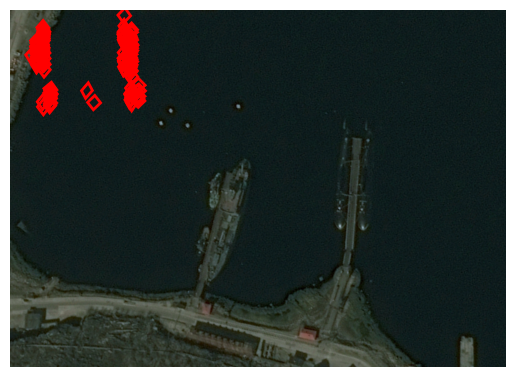

Ground Truth


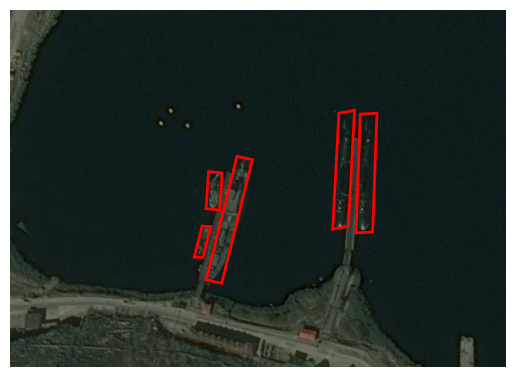

Predictions


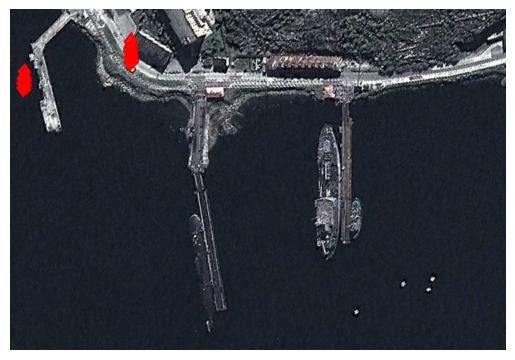

Ground Truth


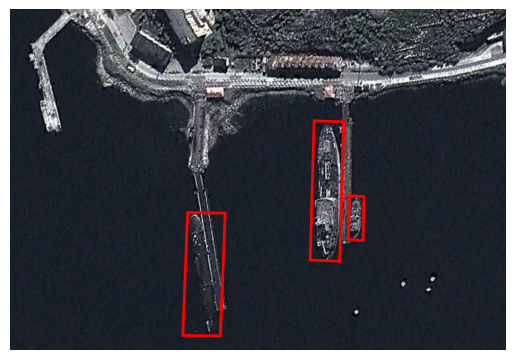

In [79]:
visualize_predictions(model, test_loader, device, num_samples=2, score_thresh=0.5)

In [76]:
def evaluate_model(model, dataloader, device):
    model.train() 
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            losses = model(images, targets)
            loss = sum(losses.values())
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Average Evaluation Loss: {avg_loss:.4f}")


In [82]:
evaluate_model(model, test_loader, device)


Evaluating:   0%|          | 0/610 [00:05<?, ?it/s]


KeyboardInterrupt: 